# Obesity Classifier Part Two

# Imports

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# Functions

In [27]:

def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: _description_
    """
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  selected_models = []
  
  for key, val in models.items():
    if key in names:
      selected_models.append(val)
  
  return selected_models

def evaluate_model(X, y, model, metric):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [6]:
df = pd.read_csv("data.csv")
df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
df.isna().sum()

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [8]:
df.duplicated().sum()

24

In [9]:
df.drop_duplicates(inplace=True)

In [17]:
target = df.values[:,-1]

counter = Counter(target)

for k, v in counter.items():
  per = v/ len(target) * 100
  print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=Normal_Weight, Count=282, Percentage=13.512%
Class=Overweight_Level_I, Count=276, Percentage=13.225%
Class=Overweight_Level_II, Count=290, Percentage=13.896%
Class=Obesity_Type_I, Count=351, Percentage=16.818%
Class=Insufficient_Weight, Count=267, Percentage=12.793%
Class=Obesity_Type_II, Count=297, Percentage=14.231%
Class=Obesity_Type_III, Count=324, Percentage=15.525%


# Fairly Balanced dataset

In [18]:
df.dtypes

Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [26]:
categorical_features = df.select_dtypes(include="object")
continuous_features = df.select_dtypes(include="float64")

In [74]:
from collections import defaultdict

def convert_categorical_to_numerical(column_values:list):
  """
  Takes categorical columns and returns them into one hot encoding columns
  without exploding the amount of columns

  Args:
      column_values (list): tuple list of index, value

  Returns:
      Dictionary Key valued pair
  """
  converted_dict = defaultdict(list)
  
  for k, v in column_values:
    converted_dict[k] = v
  return converted_dict

binary_columns, mapping_dict = [], {}
for col in categorical_features.columns:
  unique_columns_values = categorical_features[col].unique()
  print(f" Col: {col}, Unique list: {unique_columns_values}")
  if len(unique_columns_values) ==2:
    binary_columns.append(col)
  else:
    dict_values = [(value, idx )for (idx, value) in enumerate(sorted(unique_columns_values))]
    mapping_dict[col] = convert_categorical_to_numerical(dict_values)

 Col: Gender, Unique list: ['Female' 'Male']
 Col: CALC, Unique list: ['no' 'Sometimes' 'Frequently' 'Always']
 Col: FAVC, Unique list: ['no' 'yes']
 Col: SCC, Unique list: ['no' 'yes']
 Col: SMOKE, Unique list: ['no' 'yes']
 Col: family_history_with_overweight, Unique list: ['yes' 'no']
 Col: CAEC, Unique list: ['Sometimes' 'Frequently' 'Always' 'no']
 Col: MTRANS, Unique list: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
 Col: NObeyesdad, Unique list: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


# Feature Encoding

In [89]:
for k, v in mapping_dict.items():
  print(k,v)

CALC defaultdict(<class 'list'>, {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3})
CAEC defaultdict(<class 'list'>, {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3})
MTRANS defaultdict(<class 'list'>, {'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4})
NObeyesdad defaultdict(<class 'list'>, {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6})


In [90]:
# Create copy of Dataframe for feature manipulation
replicate_df = df.copy()
replicate_df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [91]:
for col in binary_columns:
  if col == "Gender":
    replicate_df[col] = replicate_df[col].apply(lambda x: 0 if x == "Female" else 1)
  else:
    replicate_df[col] = replicate_df[col].apply(lambda x: 0 if x == "no" else 1)

for k, v in mapping_dict.items():
  replicate_df[k] = replicate_df[k].apply(lambda x: v[x])


In [92]:
replicate_df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,0,1.620000,64.000000,3,0,2.0,3.0,0,0,2.000000,1,0.000000,1.000000,2,3,1
1,21.000000,0,1.520000,56.000000,2,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,2,3,1
2,23.000000,1,1.800000,77.000000,1,0,2.0,3.0,0,0,2.000000,1,2.000000,1.000000,2,3,1
3,27.000000,1,1.800000,87.000000,1,0,3.0,3.0,0,0,2.000000,0,2.000000,0.000000,2,4,5
4,22.000000,1,1.780000,89.800000,2,0,2.0,1.0,0,0,2.000000,0,0.000000,0.000000,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,0,1.710730,131.408528,2,1,3.0,3.0,0,0,1.728139,1,1.676269,0.906247,2,3,4
2107,21.982942,0,1.748584,133.742943,2,1,3.0,3.0,0,0,2.005130,1,1.341390,0.599270,2,3,4
2108,22.524036,0,1.752206,133.689352,2,1,3.0,3.0,0,0,2.054193,1,1.414209,0.646288,2,3,4
2109,24.361936,0,1.739450,133.346641,2,1,3.0,3.0,0,0,2.852339,1,1.139107,0.586035,2,3,4


In [93]:
replicate_df.dtypes

Age                               float64
Gender                              int64
Height                            float64
Weight                            float64
CALC                                int64
FAVC                                int64
FCVC                              float64
NCP                               float64
SCC                                 int64
SMOKE                               int64
CH2O                              float64
family_history_with_overweight      int64
FAF                               float64
TUE                               float64
CAEC                                int64
MTRANS                              int64
NObeyesdad                          int64
dtype: object

# Heat Map

<Axes: >

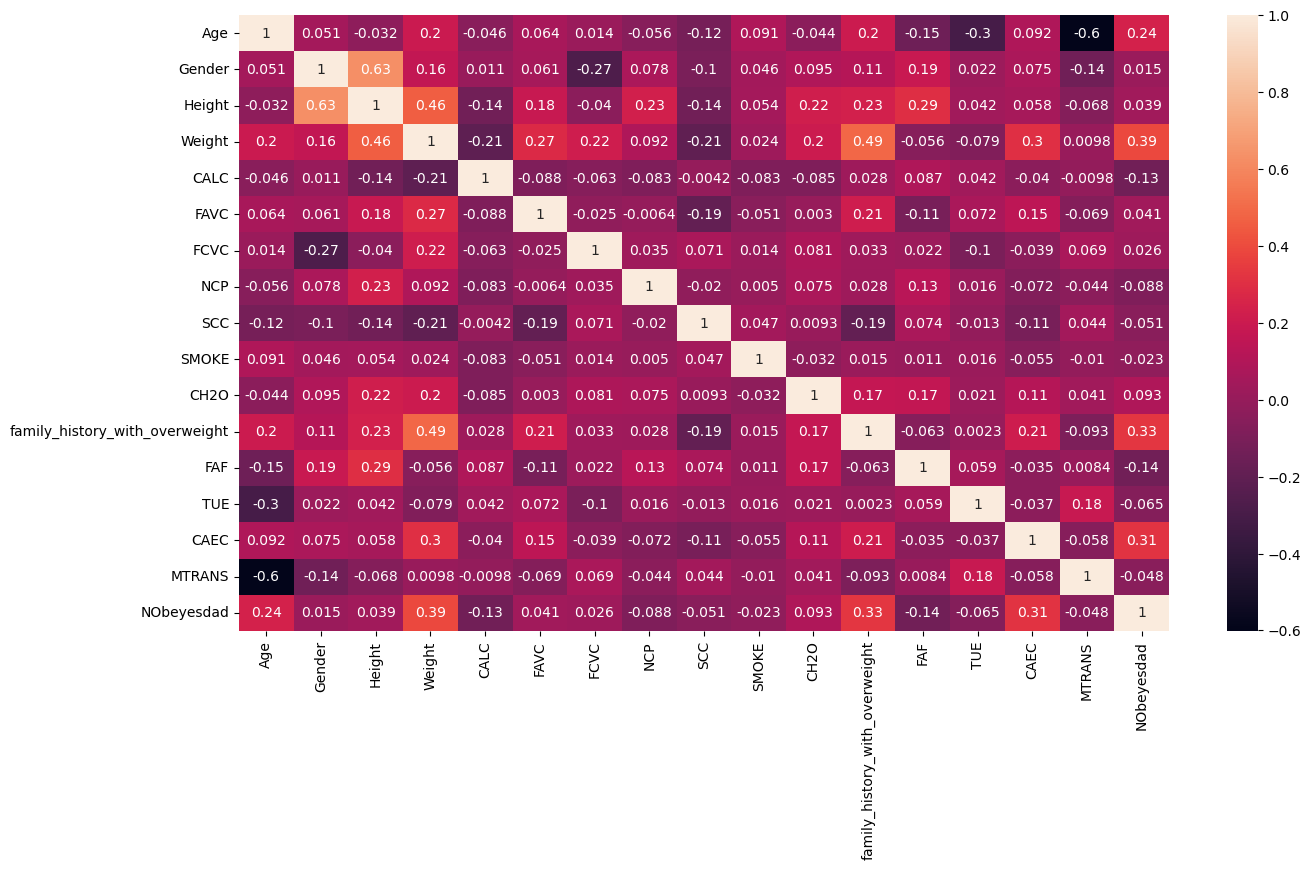

In [94]:
plt.figure(figsize=(15,8))
sns.heatmap(data=replicate_df.corr(), annot=True)